In [1]:
#Package needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import firwin, freqz
from numpy import fft

In [2]:
#Simple function to convert unsigned number in signed
def convert_tosigned(x, nbits):
    if x >= 2**(nbits-1):
        x -= 2**nbits
    return x

0.1
FIR filter coefficients:  [0.03383324 0.24012702 0.45207947 0.24012702 0.03383324]


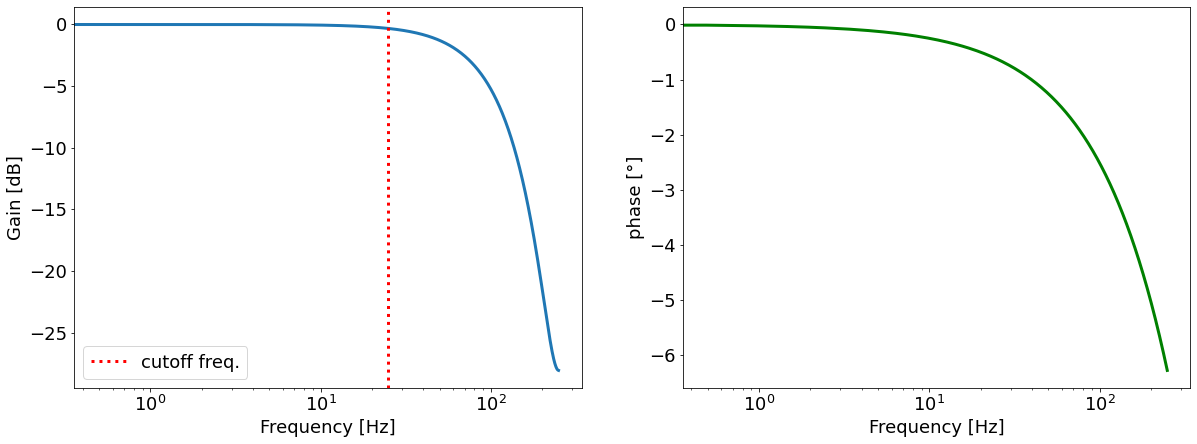

In [20]:
taps = 5
fcut = 0.1
print(fcut)
coeff = np.asarray(firwin(taps, fcut ))
print("FIR filter coefficients: ", coeff)

f, h = freqz(coeff, fs = 500)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7))
ax1.plot(f, 20*np.log10(abs(h)), lw = 3)
angles = np.unwrap(np.angle(h))
ax2.plot(f, angles, color = 'green', lw = 3)

ax1.set_xlabel('Frequency [Hz]', fontsize = 18)
ax1.set_ylabel('Gain [dB]', fontsize = 18)
#ax1.set_title('Frequency Response')
ax1.set_xscale('log')
ax1.axvline(x=25, color = 'red', ls = 'dotted', lw = 3, label = 'cutoff freq.')
ax1.legend(fontsize = 18)

ax2.set_xlabel('Frequency [Hz]', fontsize = 18)
ax2.set_ylabel('phase [°]', fontsize = 18)
#ax2.set_title('Phase Response')
ax2.set_xscale('log')

ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

plt.savefig('Bode.png', dpi = 300)
plt.show()

0.1


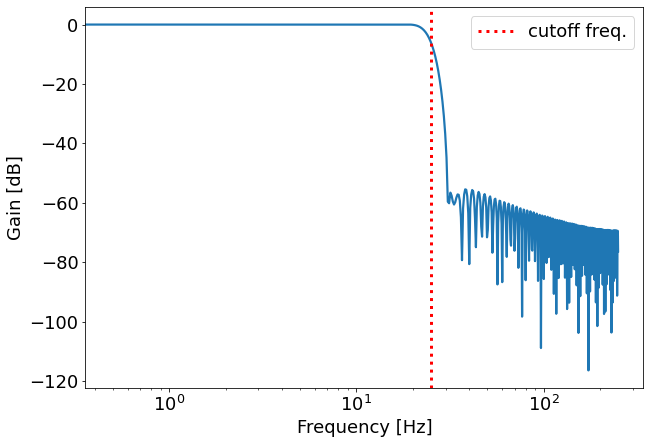

In [25]:
taps = 150
fcut = 0.1
print(fcut)
coeff = np.asarray(firwin(taps, fcut ))

f, h = freqz(coeff, fs = 500)
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 7))
ax1.plot(f, 20*np.log10(abs(h)), lw = 2.2)

ax1.set_xlabel('Frequency [Hz]', fontsize = 18)
ax1.set_ylabel('Gain [dB]', fontsize = 18)
ax1.set_xscale('log')
ax1.axvline(x=25, color = 'red', ls = 'dotted', lw = 3, label = 'cutoff freq.')
ax1.legend(fontsize = 18)

ax1.tick_params(labelsize=18)

plt.savefig('Bode_150.png', dpi = 300)
plt.show()

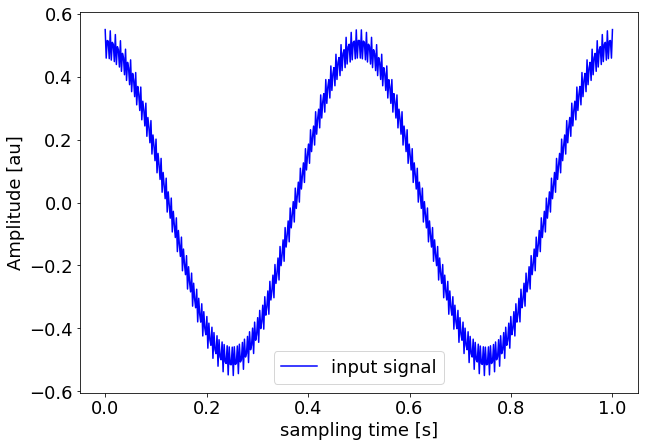

In [36]:
#Defining a noisy input signal
freq = 2
nf = 500
sampling = np.linspace(0, 1, nf)
freq_noise = 200
sig_no_noise = 0.5*np.cos(2*np.pi*freq*sampling)
noise = 0.05 * np.cos(2*np.pi*freq_noise*sampling)
sig = sig_no_noise + noise
plt.figure(figsize = (10, 7))
plt.plot(sampling, sig, label='input signal', c='blue')
plt.xlabel('sampling time [s]', fontsize = 18)
plt.legend(fontsize = 18)
plt.ylabel('Amplitude [au]', fontsize = 18)
plt.tick_params(labelsize=18)
plt.savefig('Input_signal.png', dpi = 300)
plt.show()

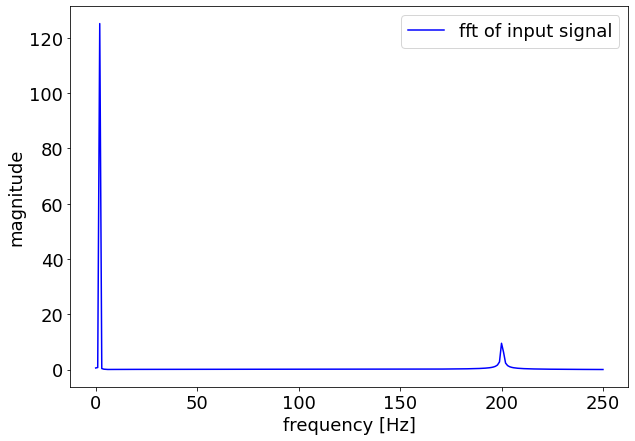

In [37]:
spectrum_sampl = fft.rfft(sig, nf)
freq_fourier = fft.rfftfreq(nf, d=1/nf)
plt.figure(figsize = (10, 7))
plt.xlabel('frequency [Hz]', fontsize = 18)
plt.ylabel('magnitude', fontsize = 18)
plt.plot(freq_fourier, np.abs(spectrum_sampl), label='fft of input signal', c='blue')
plt.legend(fontsize = 18)
plt.tick_params(labelsize=18)
plt.savefig('Input_signal_fft.png', dpi = 300)
plt.show()

In [38]:
#Write 'sig' to file with conversion to signed integer for the FPGA
ofile = open('input_signal.txt', 'w')
sig_uns = np.zeros_like(sig)
sig_bin = np.zeros_like(sig)
for i in range(sig.size):
    sig_bin[i] = int(sig[i]*2**7)
    sig_uns[i] = int(np.binary_repr(int(sig[i]*2**7), width = 8), 2)
    ofile.write(str(int(sig_uns[i])) + '\n')
ofile.close()

## IDEAL BEAHAVIOUR

In [7]:
index = int((taps-1)/2)
filt_sig = np.zeros_like(sig)
for i in range(sig.size-taps+1):
    filt_sig[i+index] = np.dot(sig[i:taps+i], coeff[::-1])

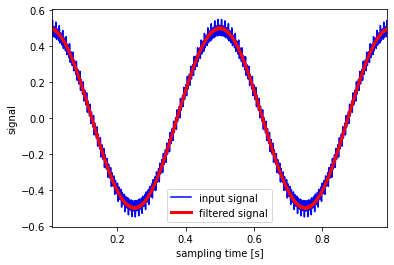

In [8]:
plt.plot(sampling, sig, c='blue', label='input signal')
plt.plot(sampling, filt_sig, c='r', label='filtered signal', lw = 3)
plt.xlim(0.01, 0.99)
plt.xlabel('sampling time [s]')
plt.ylabel('signal')
plt.legend(fontsize = 18)

plt.show()

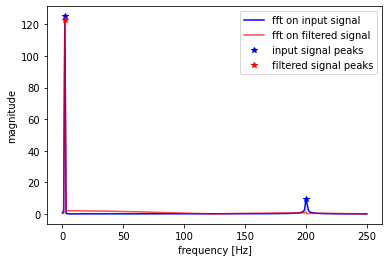

In [9]:
spectrum_filtered = fft.rfft(filt_sig, nf)
freq_filtered = fft.rfftfreq(nf, d=1/nf)



magnitude = np.abs(spectrum_sampl)
peaks, _ = scipy.signal.find_peaks(magnitude, height=5)

magnitude_filt = np.abs(spectrum_filtered)
peaks_filt, _ = scipy.signal.find_peaks(magnitude_filt, height=5)


plt.plot(freq_fourier, np.abs(spectrum_sampl), c='blue', label='fft on input signal')
plt.plot(freq_filtered, np.abs(spectrum_filtered), c='red', label='fft on filtered signal', alpha=0.7)
plt.plot(freq_fourier[peaks], magnitude[peaks], '*', label='input signal peaks', c='blue')
plt.plot(freq_filtered[peaks_filt], magnitude_filt[peaks_filt], '*', label='filtered signal peaks', c='r')
plt.legend(loc='best')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude')
plt.show()

In [10]:
print('input signal frequency analysis')
for i in peaks:
    str0 = f'frequency at which the input signal dispays peaks: {freq_fourier[i]} magnitude {magnitude[i]}'
    print(str0)

print('filtered signal frequency analysis')
for i in peaks_filt:
    str0 = f'frequency at which the filtered signal dispays peaks: {freq_filtered[i]} magnitude {magnitude_filt[i]}'
    print(str0)

input signal frequency analysis
frequency at which the input signal dispays peaks: 2.0 magnitude 125.17183675828915
frequency at which the input signal dispays peaks: 200.0 magnitude 9.48971658018734
filtered signal frequency analysis
frequency at which the filtered signal dispays peaks: 2.0 magnitude 123.09623140078173


In [11]:
ofile = open('ideal_output_signal.txt', 'w')
filt_sig_bin = np.zeros_like(filt_sig)
for i in range(filt_sig.size):
    filt_sig_bin[i] = int(filt_sig[i]*2**7)
    ofile.write(str(filt_sig_bin[i]) + '\n')
ofile.close()

## SIMULATION

In [13]:
coeff_int = np.zeros_like(coeff)
coeff_bin = []

for i in range(taps):
    coeff_int[i] = (round(coeff[i]*2**7, 0))

for i in range(taps):
    coeff_bin.append(bin(int(coeff_int[i])))

print(coeff_int, '\n', coeff_bin)

[ 4. 31. 58. 31.  4.] 
 ['0b100', '0b11111', '0b111010', '0b11111', '0b100']


In [14]:
y = np.zeros_like(sig)
sim_filt_sig = np.zeros_like(sig_uns)
for i in range(sig_bin.size-taps+1):
    y[i+index] = np.dot(sig_bin[i:taps+i], coeff_int[::-1])
    bin_19 = np.binary_repr(int(y[i+index]), 19)
    bin_8 = bin_19[4:12]
    int_8 = int(bin_8, 2)
    sim_filt_sig[i+index] = convert_tosigned(int_8, 8)

In [15]:
df = pd.DataFrame()
df['Bin input uns'] = sig_uns
df['Bin input'] = sig_bin
df['Bin output'] = filt_sig_bin
df['Bin sim. output'] = sim_filt_sig

In [16]:
df.to_csv('Results.csv')

## Data fro FPGA

(498,)
(2,)


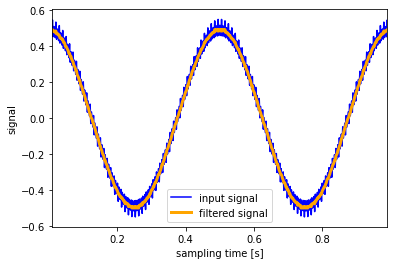

In [17]:
fpga = np.loadtxt('output_signal.txt')/2**7
print(fpga[2:].shape)
print(np.zeros(2).shape)
new = np.concatenate([fpga[2:], np.zeros(2)])
plt.plot(sampling, sig, c='blue', label='input signal')
plt.plot(sampling, new, c='orange', label='filtered signal', lw = 3)
plt.xlim(0.01, 0.99)
plt.xlabel('sampling time [s]')
plt.ylabel('signal')
plt.legend(loc='best')
plt.show()

(0.0, 0.5)

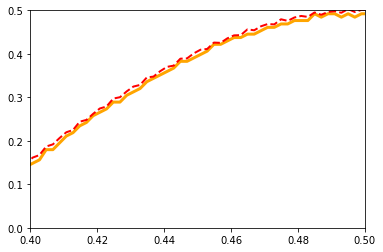

In [18]:
plt.plot(sampling, new, c='orange', label='filtered signal', lw = 3)
plt.plot(sampling, filt_sig, c='r', label='filtered signal', lw = 2, ls = '--')
plt.xlim(0.4, 0.5)
plt.ylim(0.0, 0.5)